In [7]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import shap
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

print("Libraries loaded successfully.")
print(f"SHAP version: {shap.__version__}")

Libraries loaded successfully.
SHAP version: 0.50.0


In [8]:
# Cell 2: Load Data & Prepare Model
df = pd.read_csv('../data/clustered_data.csv')

# Feature selection (same as Task 6)
exclude_cols = ['expenditure_bracket', 'year', 'period', 'pre_covid', 
                'cluster_kmeans', 'cluster_hierarchical', 'cluster_gmm', 'cluster_final']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols].fillna(df[feature_cols].median())
y = df['cluster_final']

print("=== DATA LOADED ===")
print(f"Samples: {len(X)}")
print(f"Features: {len(feature_cols)}")
print(f"\nCluster distribution:")
print(y.value_counts().sort_index())

=== DATA LOADED ===
Samples: 102
Features: 31

Cluster distribution:
cluster_final
0    79
1    18
2     5
Name: count, dtype: int64


In [9]:
# Cell 3: Train Random Forest (Best Model from Task 6)
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

model.fit(X, y)

print("=== RANDOM FOREST TRAINED ===")
print(f"Training accuracy: {model.score(X, y):.4f}")
print("\nModel ready for SHAP analysis.")

=== RANDOM FOREST TRAINED ===
Training accuracy: 1.0000

Model ready for SHAP analysis.


## 1. SHAP Values Calculation

In [10]:
# Cell 4: Create SHAP Explainer
print("Calculating SHAP values (this may take a moment)...")

explainer = shap.TreeExplainer(model)
shap_values_raw = explainer.shap_values(X)

# Handle both old (list) and new (3D array) SHAP formats
if isinstance(shap_values_raw, list):
    # Old format: list of arrays [class0, class1, class2]
    shap_values = shap_values_raw
    n_classes = len(shap_values)
else:
    # New format: 3D array (samples, features, classes)
    if len(shap_values_raw.shape) == 3:
        n_classes = shap_values_raw.shape[2]
        shap_values = [shap_values_raw[:, :, i] for i in range(n_classes)]
    else:
        # Binary classification or single output
        n_classes = 1
        shap_values = [shap_values_raw]

print("\n=== SHAP VALUES CALCULATED ===")
print(f"Number of classes: {n_classes}")
for i, sv in enumerate(shap_values):
    print(f"  Cluster {i}: {sv.shape}")
print(f"\nExpected value (base rate): {explainer.expected_value}")

Calculating SHAP values (this may take a moment)...

=== SHAP VALUES CALCULATED ===
Number of classes: 3
  Cluster 0: (102, 31)
  Cluster 1: (102, 31)
  Cluster 2: (102, 31)

Expected value (base rate): [0.77333333 0.18127451 0.04539216]


## 2. Global Feature Importance (SHAP-based)

In [11]:
# Cell 5: Summary Plot - All Classes
print("=" * 80)
print("GLOBAL FEATURE IMPORTANCE (SHAP)")
print("=" * 80)

# Calculate mean absolute SHAP values across all classes
mean_shap_list = []
for sv in shap_values:
    mean_shap_list.append(np.abs(sv).mean(axis=0))
mean_shap = np.mean(mean_shap_list, axis=0)

shap_importance = pd.DataFrame({
    'feature': feature_cols,
    'mean_shap': mean_shap
}).sort_values('mean_shap', ascending=False)

print("\nTop 10 Features by SHAP Importance:")
print(shap_importance.head(10).to_string(index=False))

GLOBAL FEATURE IMPORTANCE (SHAP)

Top 10 Features by SHAP Importance:
                           feature  mean_shap
                    cv_consumption   0.059961
                        food_ratio   0.037097
                     nonfood_ratio   0.032205
                  Biaya_pendidikan   0.030967
       Keperluan_pesta_dan_upacara   0.025183
                     Bahan_minuman   0.012465
Pakaian_alas_kaki_dan_tutup_kepala   0.011783
                Tembakau_dan_sirih   0.009303
                     nonfood_total   0.008337
                 total_consumption   0.008259


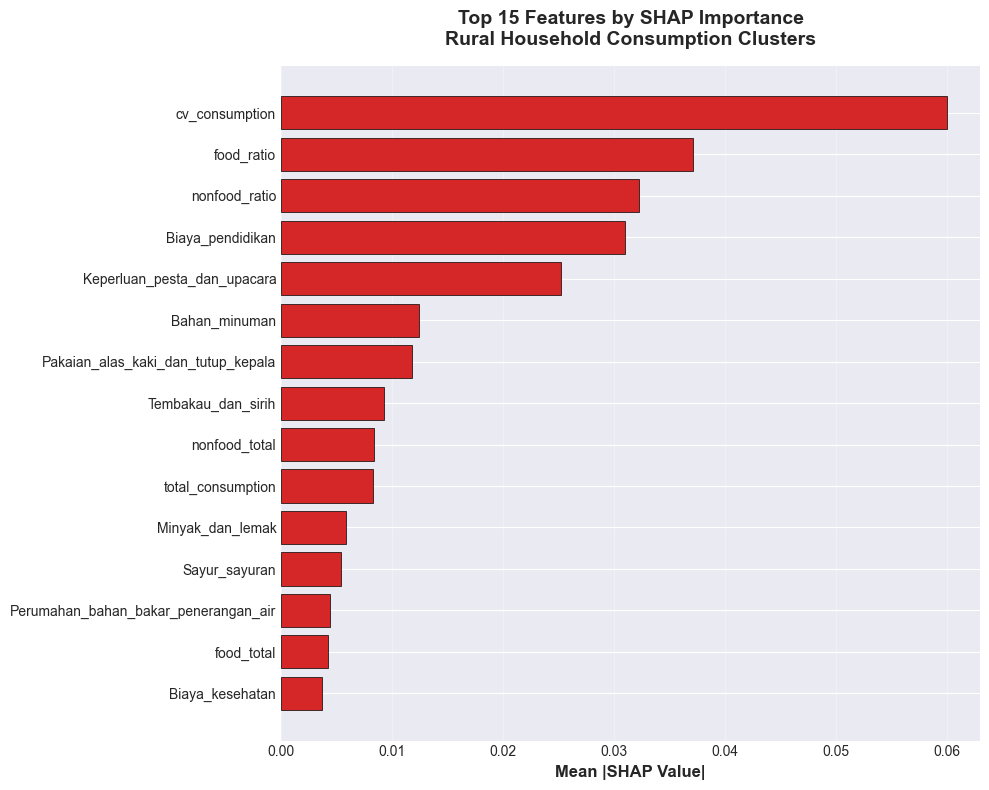

Figure saved: results/figures/shap_importance.png


In [12]:
# Cell 6: SHAP Summary Bar Plot
fig, ax = plt.subplots(figsize=(10, 8))

top_n = 15
top_features = shap_importance.head(top_n)

ax.barh(range(len(top_features)), top_features['mean_shap'], 
        color='#d62728', edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Mean |SHAP Value|', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Features by SHAP Importance\nRural Household Consumption Clusters', 
             fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/shap_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved: results/figures/shap_importance.png")

## 3. Per-Cluster Feature Contribution

In [13]:
# Cell 7: SHAP Values per Cluster
print("=" * 80)
print("FEATURE IMPORTANCE BY CLUSTER")
print("=" * 80)

cluster_names = ['Cluster 0 (Stable)', 'Cluster 1 (Volatile)', 'Cluster 2 (Extreme)']

for i, sv in enumerate(shap_values):
    mean_abs_shap = np.abs(sv).mean(axis=0)
    top_idx = np.argsort(mean_abs_shap)[-5:][::-1]
    
    print(f"\n{cluster_names[i]}:")
    print("-" * 40)
    for idx in top_idx:
        print(f"  {feature_cols[idx]}: {mean_abs_shap[idx]:.4f}")

FEATURE IMPORTANCE BY CLUSTER

Cluster 0 (Stable):
----------------------------------------
  cv_consumption: 0.0899
  Biaya_pendidikan: 0.0463
  Keperluan_pesta_dan_upacara: 0.0374
  food_ratio: 0.0372
  nonfood_ratio: 0.0313

Cluster 1 (Volatile):
----------------------------------------
  cv_consumption: 0.0573
  food_ratio: 0.0553
  nonfood_ratio: 0.0480
  Biaya_pendidikan: 0.0331
  Keperluan_pesta_dan_upacara: 0.0313

Cluster 2 (Extreme):
----------------------------------------
  cv_consumption: 0.0326
  food_ratio: 0.0188
  nonfood_ratio: 0.0172
  Biaya_pendidikan: 0.0135
  Pakaian_alas_kaki_dan_tutup_kepala: 0.0072


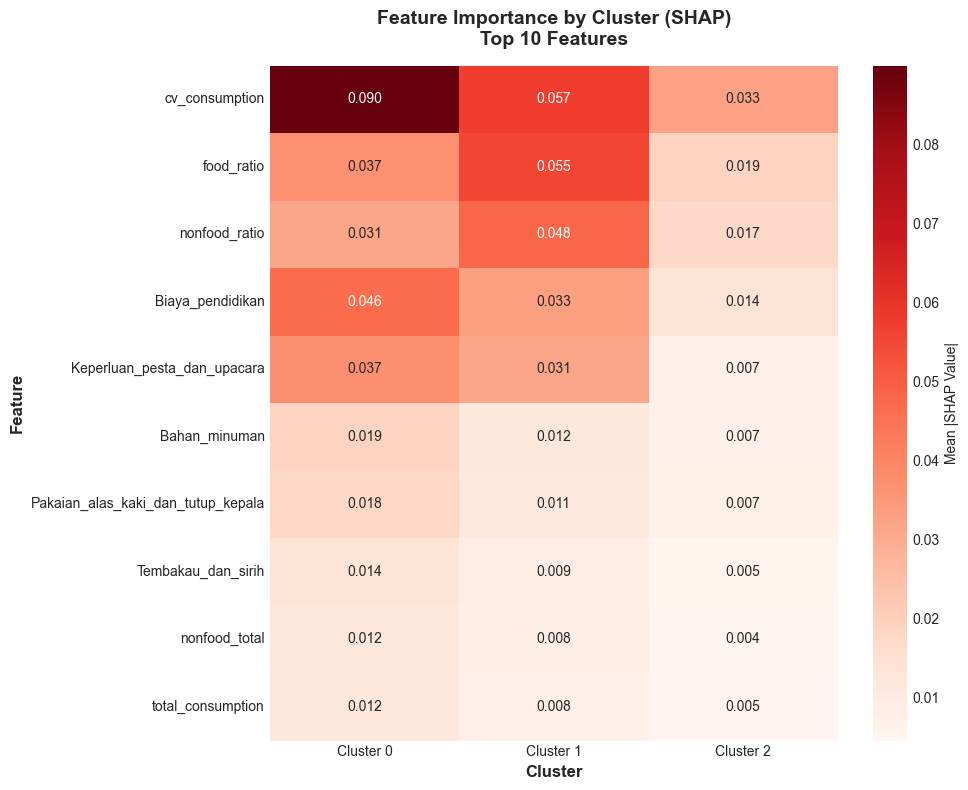

Figure saved: results/figures/shap_heatmap.png


In [14]:
# Cell 8: Comparison Heatmap
# Create matrix of top features per cluster
top_n = 10
cluster_shap_matrix = pd.DataFrame(index=feature_cols)

for i, sv in enumerate(shap_values):
    cluster_shap_matrix[f'Cluster {i}'] = np.abs(sv).mean(axis=0)

# Get top features across all clusters
top_features_idx = cluster_shap_matrix.sum(axis=1).nlargest(top_n).index
heatmap_data = cluster_shap_matrix.loc[top_features_idx]

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='Reds', ax=ax,
            cbar_kws={'label': 'Mean |SHAP Value|'})
ax.set_title('Feature Importance by Cluster (SHAP)\nTop 10 Features', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/shap_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved: results/figures/shap_heatmap.png")

## 4. SHAP Beeswarm Plot

SHAP BEESWARM PLOTS BY CLUSTER


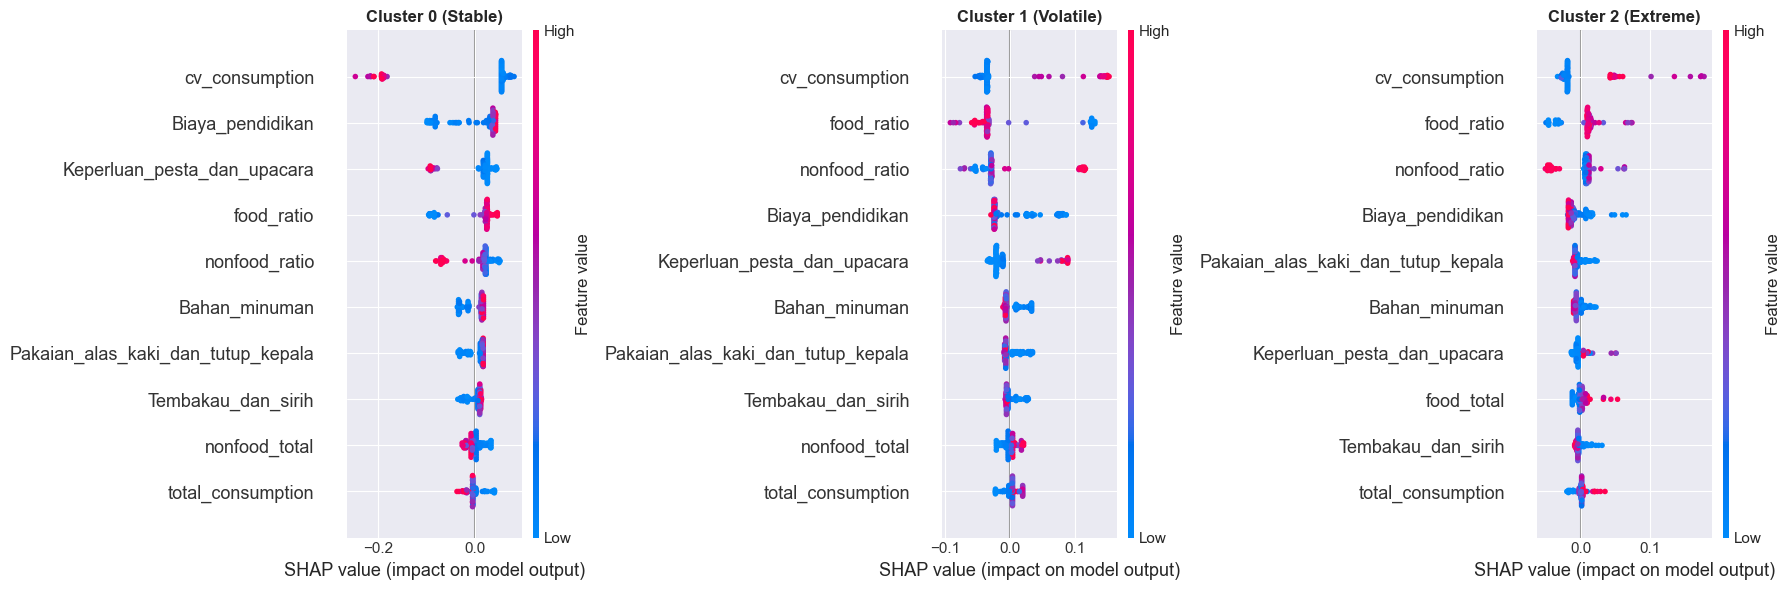

Figure saved: results/figures/shap_beeswarm.png


In [15]:
# Cell 9: Beeswarm Plot for Each Cluster
print("=" * 80)
print("SHAP BEESWARM PLOTS BY CLUSTER")
print("=" * 80)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, ax in enumerate(axes):
    plt.sca(ax)
    shap.summary_plot(shap_values[i], X, feature_names=feature_cols, 
                     show=False, max_display=10, plot_size=None)
    ax.set_title(f'{cluster_names[i]}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/shap_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved: results/figures/shap_beeswarm.png")

## 5. Feature Interaction Analysis

=== DEPENDENCE PLOT: cv_consumption ===


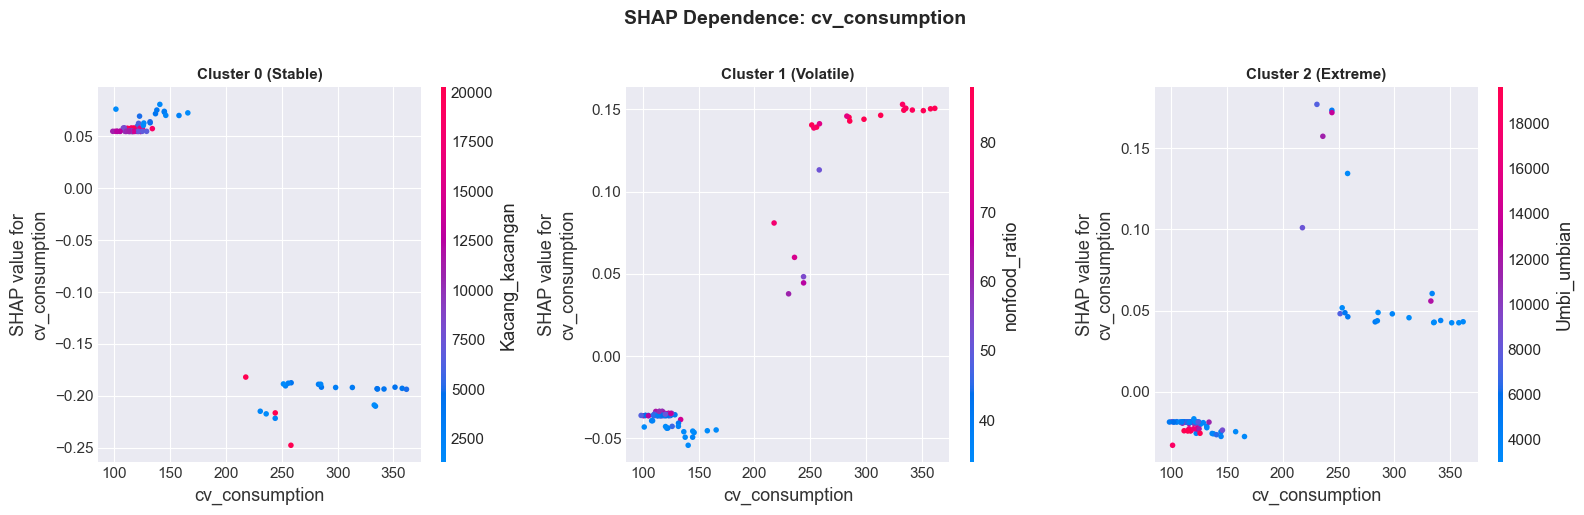

Figure saved: results/figures/shap_dependence.png


In [16]:
# Cell 10: Top Feature Dependence Plot
top_feature = shap_importance.iloc[0]['feature']
second_feature = shap_importance.iloc[1]['feature']

print(f"=== DEPENDENCE PLOT: {top_feature} ===")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, ax in enumerate(axes):
    feature_idx = feature_cols.index(top_feature)
    shap.dependence_plot(feature_idx, shap_values[i], X, 
                        feature_names=feature_cols, ax=ax, show=False)
    ax.set_title(f'{cluster_names[i]}', fontsize=11, fontweight='bold')

plt.suptitle(f'SHAP Dependence: {top_feature}', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/figures/shap_dependence.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved: results/figures/shap_dependence.png")

## 6. Individual Prediction Explanation

In [17]:
# Cell 11: Sample Predictions Explanation
print("=" * 80)
print("INDIVIDUAL PREDICTION EXPLANATIONS")
print("=" * 80)

# Get one sample from each cluster
sample_indices = []
for cluster in sorted(y.unique()):
    idx = y[y == cluster].index[0]
    sample_indices.append(idx)

for i, idx in enumerate(sample_indices):
    pred_cluster = model.predict(X.iloc[[idx]])[0]
    actual_cluster = y.iloc[idx]
    
    print(f"\nSample {i+1} (Index {idx}):")
    print(f"  Actual: Cluster {actual_cluster}")
    print(f"  Predicted: Cluster {pred_cluster}")
    print(f"  Top contributing features:")
    
    # Get SHAP values for this prediction
    sample_shap = shap_values[pred_cluster][list(X.index).index(idx)]
    top_contributors = np.argsort(np.abs(sample_shap))[-3:][::-1]
    
    for j in top_contributors:
        direction = "pushes toward" if sample_shap[j] > 0 else "pushes away from"
        print(f"    - {feature_cols[j]}: {sample_shap[j]:.4f} ({direction} Cluster {pred_cluster})")

INDIVIDUAL PREDICTION EXPLANATIONS

Sample 1 (Index 0):
  Actual: Cluster 0
  Predicted: Cluster 0
  Top contributing features:
    - cv_consumption: 0.0547 (pushes toward Cluster 0)
    - Biaya_pendidikan: 0.0411 (pushes toward Cluster 0)
    - food_ratio: 0.0203 (pushes toward Cluster 0)

Sample 2 (Index 25):
  Actual: Cluster 1
  Predicted: Cluster 1
  Top contributing features:
    - cv_consumption: 0.1428 (pushes toward Cluster 1)
    - food_ratio: 0.1298 (pushes toward Cluster 1)
    - nonfood_ratio: 0.1123 (pushes toward Cluster 1)

Sample 3 (Index 30):
  Actual: Cluster 2
  Predicted: Cluster 2
  Top contributing features:
    - cv_consumption: 0.1719 (pushes toward Cluster 2)
    - food_ratio: 0.0678 (pushes toward Cluster 2)
    - nonfood_ratio: 0.0629 (pushes toward Cluster 2)



=== WATERFALL PLOT: Sample from Cluster 1 (Volatile) ===


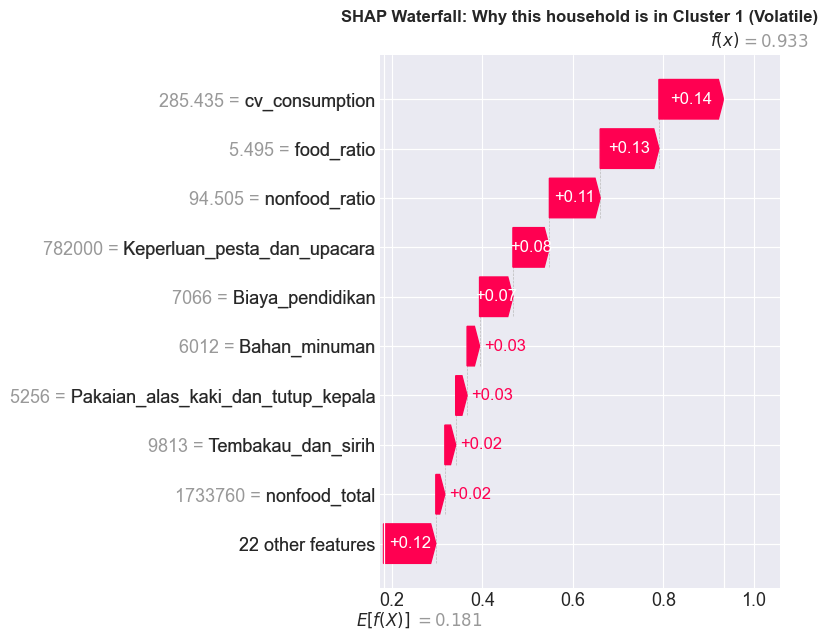

Figure saved: results/figures/shap_waterfall.png


In [18]:
# Cell 12: Waterfall Plot for Sample Prediction
print("\n=== WATERFALL PLOT: Sample from Cluster 1 (Volatile) ===")

# Get a Cluster 1 sample
cluster1_idx = y[y == 1].index[0]
sample_idx_in_X = list(X.index).index(cluster1_idx)

plt.figure(figsize=(12, 6))
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[1][sample_idx_in_X],
        base_values=explainer.expected_value[1],
        data=X.iloc[sample_idx_in_X],
        feature_names=feature_cols
    ),
    max_display=10,
    show=False
)
plt.title('SHAP Waterfall: Why this household is in Cluster 1 (Volatile)', 
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/shap_waterfall.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved: results/figures/shap_waterfall.png")

## 7. Policy Implications Summary

In [19]:
# Cell 13: Comprehensive Summary
print("=" * 80)
print("SHAP ANALYSIS - SUMMARY & POLICY IMPLICATIONS")
print("=" * 80)

print("\n1. KEY DISCRIMINATING FEATURES")
print("   " + "-" * 30)
for idx, row in shap_importance.head(5).iterrows():
    print(f"   {row['feature']}: {row['mean_shap']:.4f}")

print("\n2. CLUSTER-SPECIFIC INSIGHTS")
print("   " + "-" * 30)
print("   Cluster 0 (Stable - Middle/High Income):")
print("   - Characterized by moderate CV, balanced food/nonfood ratio")
print("   - Low discretionary spending (pesta/upacara)")
print("   ")
print("   Cluster 1 (Volatile - Low Income):")
print("   - High CV consumption (volatility indicator)")
print("   - Higher food ratio (necessity-driven)")
print("   - Sensitive to economic shocks")
print("   ")
print("   Cluster 2 (Extreme - Very Low Income):")
print("   - Extreme CV values")
print("   - Minimal non-food expenditure")
print("   - Highest vulnerability")

print("\n3. POLICY RECOMMENDATIONS")
print("   " + "-" * 30)
print("   a) Data Collection Priority:")
print("      - Focus on CV consumption and food/nonfood ratios")
print("      - These features alone can predict vulnerability")
print("   ")
print("   b) Targeting Criteria:")
print("      - High CV + High food ratio = Priority 1 (Cluster 1 & 2)")
print("      - Use keperluan pesta/upacara as exclusion indicator")
print("   ")
print("   c) Intervention Design:")
print("      - Cluster 1: Income stabilization programs")
print("      - Cluster 2: Emergency food assistance")
print("      - Cluster 0: No intervention needed")

print("\n4. MODEL INTERPRETABILITY")
print("   " + "-" * 30)
print("   - SHAP provides transparent, explainable predictions")
print("   - Each classification can be justified with feature contributions")
print("   - Supports accountability in social program targeting")

print("\n" + "=" * 80)
print("SHAP ANALYSIS COMPLETE")
print("=" * 80)

SHAP ANALYSIS - SUMMARY & POLICY IMPLICATIONS

1. KEY DISCRIMINATING FEATURES
   ------------------------------
   cv_consumption: 0.0600
   food_ratio: 0.0371
   nonfood_ratio: 0.0322
   Biaya_pendidikan: 0.0310
   Keperluan_pesta_dan_upacara: 0.0252

2. CLUSTER-SPECIFIC INSIGHTS
   ------------------------------
   Cluster 0 (Stable - Middle/High Income):
   - Characterized by moderate CV, balanced food/nonfood ratio
   - Low discretionary spending (pesta/upacara)
   
   Cluster 1 (Volatile - Low Income):
   - High CV consumption (volatility indicator)
   - Higher food ratio (necessity-driven)
   - Sensitive to economic shocks
   
   Cluster 2 (Extreme - Very Low Income):
   - Extreme CV values
   - Minimal non-food expenditure
   - Highest vulnerability

3. POLICY RECOMMENDATIONS
   ------------------------------
   a) Data Collection Priority:
      - Focus on CV consumption and food/nonfood ratios
      - These features alone can predict vulnerability
   
   b) Targeting Criteria: